In [1]:
# ========== Step 1: Import Required Libraries ==========
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

In [2]:
# ========== Step 2: Unzip Dataset ==========
zip_path = "/content/catsanddogs.zip"  # your dataset zip
extract_path = "/content/dataset"
train_path = os.path.join(extract_path, "train")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.makedirs(train_path, exist_ok=True)
cat_folder = os.path.join(extract_path, "cats_set")
dog_folder = os.path.join(extract_path, "dogs_set")

for filename in os.listdir(cat_folder):
    if filename.lower().endswith((".jpg", ".png")):
        shutil.move(os.path.join(cat_folder, filename), os.path.join(train_path, filename))
for filename in os.listdir(dog_folder):
    if filename.lower().endswith((".jpg", ".png")):
        shutil.move(os.path.join(dog_folder, filename), os.path.join(train_path, filename))
shutil.rmtree(cat_folder)
shutil.rmtree(dog_folder)

In [3]:
# ========== Step 3: Create DataFrame ==========
filenames = os.listdir(train_path)
categories = ['dog' if fname.startswith('dog') else 'cat' for fname in filenames]
df = pd.DataFrame({'filename': filenames, 'category': categories})
train_df, validate_df = train_test_split(df, test_size=0.3, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [4]:
# ========== Step 4: Preprocess Data ==========
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=32
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=32
)


Found 700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [5]:
# ========== Step 5: Build CNN Model ==========
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,786 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [6]:
# ========== Step 6: Train Model ==========
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5487 - loss: 1.9178

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5495 - loss: 1.9031 - val_accuracy: 0.5000 - val_loss: 3.0282
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5976 - loss: 1.1047 - val_accuracy: 0.5000 - val_loss: 1.1793
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6098 - loss: 1.0118 - val_accuracy: 0.5000 - val_loss: 2.5159
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5960 - loss: 1.0322 - val_accuracy: 0.5000 - val_loss: 1.0627
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6036 - loss: 0.8815 - val_accuracy: 0.5400 - val_loss: 0.6920
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6369 - loss: 0.7781 - val_accuracy: 0.4733 - val_loss: 0.8442
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6619 - loss: 0.7758 - val_accuracy: 0.5000 - val_loss: 1.6551
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6605 - loss: 0.6819 - val_accuracy: 0.5000 - val_loss: 1.8124
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7231 - loss: 0.5703 - val_accuracy: 0.6100 - val_loss: 0.6855
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7268 - loss: 0.5860 - val_accuracy: 0.5233 - val_loss: 0.7761
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7228 - loss: 0.5651 - val_accuracy: 0.5733 - val_loss: 0.7550
Epoch 16/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7375 - loss: 0.5354 - val_accuracy: 0.5433 - val_loss: 0.8350
Epoch 17/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7479 - loss: 0.5278 - val_accuracy: 0.6233 - val_loss: 0.7080
Epoch 18/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7740 - loss: 0.5108 - val_accuracy: 0.5667 - val_loss: 0.8141
Epoch 19/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7260 - loss: 0.5010 - val_accuracy: 0.6333 - val_loss: 0.7725
Epoch 20/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7423 - loss: 0.5337 - val_accuracy: 0.6400 - val_loss: 0.6

In [7]:
# ========== Step 7: Save Model ==========
model.save('/content/cats_vs_dogs_model.h5')

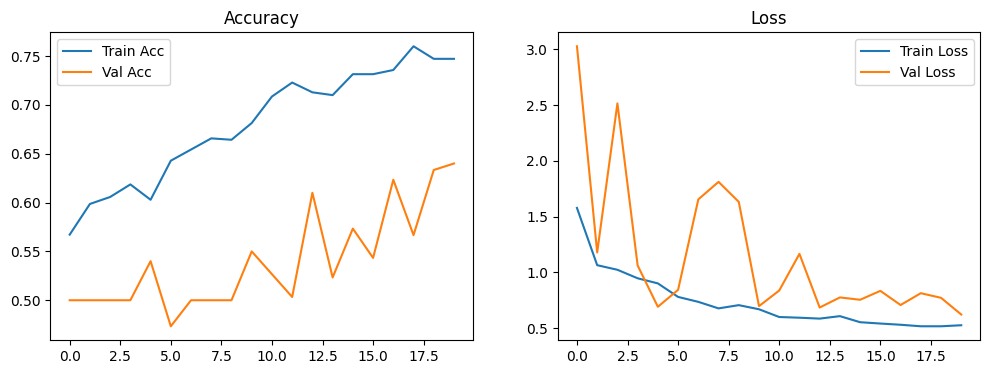

In [8]:
# ========== Step 8: Plot Accuracy and Loss ==========
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


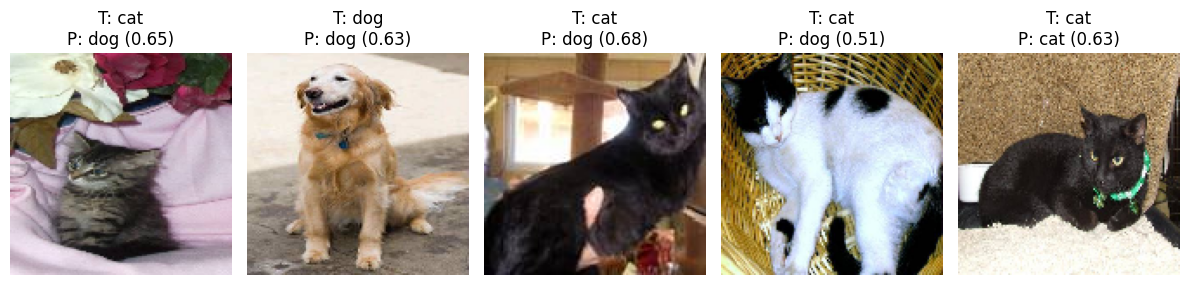

In [13]:
# ========== Step 9: Predict & Display 5 Random Validation Images ==========
sample_test = validate_df.sample(5)
plt.figure(figsize=(12, 6))
model = load_model('/content/cats_vs_dogs_model.h5')

for i, row in enumerate(sample_test.iterrows()):
    filename = row[1]['filename']
    true_label = row[1]['category']
    img_path = os.path.join(train_path, filename)

    # Load and preprocess image
    image = load_img(img_path, target_size=IMAGE_SIZE)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Predict using trained model
    prediction = model.predict(image_array)
    predicted_label = 'cat' if np.argmax(prediction) == 0 else 'dog'
    confidence = np.max(prediction)

    # Plot
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"T: {true_label}\nP: {predicted_label} ({confidence:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


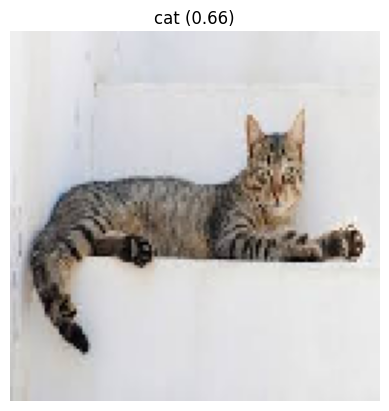

In [12]:
# ========== Step 10: Classify Unseen Image ==========
def classify_image(image_path):
    model = load_model('/content/cats_vs_dogs_model.h5')
    image = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(image)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_names = ['cat', 'dog']
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    plt.imshow(image)
    plt.title(f"{predicted_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example usage
model = load_model('/content/cats_vs_dogs_model.h5')

Saving cat.jpg to cat (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


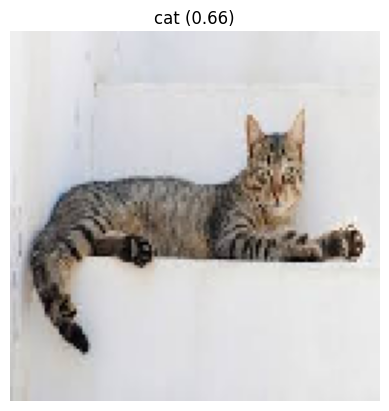

In [15]:
# ========== Classify Unseen Image (Upload option) ==========
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load model
model = load_model('/content/cats_vs_dogs_model.h5')
class_names = ['cat', 'dog']

# Upload image
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load and preprocess image
    image = load_img(file_name, target_size=IMAGE_SIZE)
    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"{predicted_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 672ms/step


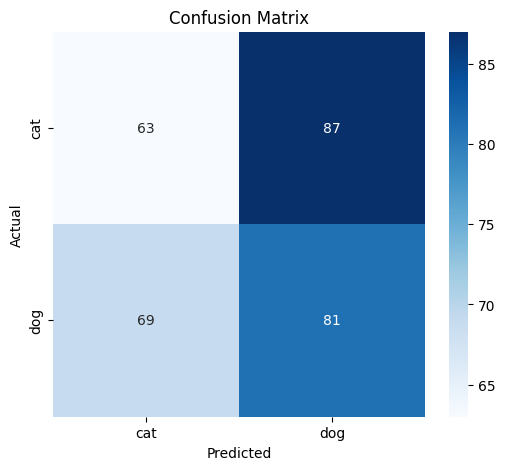

Classification Report:
               precision    recall  f1-score   support

         cat       0.48      0.42      0.45       150
         dog       0.48      0.54      0.51       150

    accuracy                           0.48       300
   macro avg       0.48      0.48      0.48       300
weighted avg       0.48      0.48      0.48       300



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ========== Step 11: Confusion Matrix ==========
# Get ground truth and predictions
validation_generator.reset()
pred = model.predict(validation_generator, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)

# True class indices
true_class_indices = validation_generator.classes

# Class labels
labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
cr = classification_report(true_class_indices, predicted_class_indices, target_names=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", cr)
